# Taller 2: Regresión

In [885]:

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor


In [886]:
df = pd.read_csv('data/training_pruebas.csv', header=0)
dfTest = pd.read_csv('data/test_pruebas.csv', header=0)

C:\Users\Migue\AppData\Local\Temp\ipykernel_16624\874024968.py:1: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/training_pruebas.csv', header=0)
C:\Users\Migue\AppData\Local\Temp\ipykernel_16624\874024968.py:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  dfTest = pd.read_csv('data/test_pruebas.csv', header=0)


In [887]:
dfFinal = df['PUNT_GLOBAL']

# Exploración de datos

Despues de realizar una exploración visual de las variables y que significaban cada una se escogieron las siguientes
- ESTU_GENERO
- ESTU_FECHANACIMIENTO -> EDAD
- PERIODO
- ESTU_DEPTO_RESIDE
- ESTU_AREARESIDE
- ESTU_TITULOOBTENIDOBACHILLER
- ESTU_VALORMATRICULAUNIVERSIDAD
- ESTU_PAGOMATRICULA
- ESTU_COMOCAPACITOEXAMENSB11
- ESTU_SEMESTRECURSA
- FAMI_EDUCACIONPADRE
- FAMI_EDUCACIONMADRE
- FAMI_ESTRATOVIVIENDA
- FAMI_TIENEINTERNET
- FAMI_TIENESERVICIOTV
- FAMI_TIENECOMPUTADOR
- FAMI_TIENECONSOLAVIDEOJUEGOS
- ESTU_HORASSEMANATRABAJA
- GRUPOREFERENCIA
- ESTU_PRGM_DEPARTAMENTO
- ESTU_METODO_PRGM
- INST_CARACTER_ACADEMICO
- ESTU_INSE_INDIVIDUAL
- ESTU_NSE_IES

A estas variables se les hara algunas exploraciones y transformaciones segun se requiera. Estas variables no son las escogidas como finales para crear el modelo si no como las escogidas despues de una exploración basica de los datos
___

In [888]:
def calcular_correlacion_dummies(df, columna_categoria, columna_objetivo):
    """
    Calcula la correlación entre las variables dummy creadas a partir de una columna categórica
    y una variable objetivo.

    Parámetros:
    df (DataFrame): El DataFrame que contiene los datos.
    columna_categoria (str): El nombre de la columna categórica para crear las dummies.
    columna_objetivo (str): El nombre de la columna objetivo para calcular la correlación.

    Retorna:
    DataFrame: Un DataFrame con las correlaciones entre las dummies y la variable objetivo.
    """
    df_dummies = pd.get_dummies(df[columna_categoria])
    
    df_con_dummies = pd.concat([df, df_dummies], axis=1)
    
    correlaciones = df_con_dummies[df_dummies.columns].corrwith(df[columna_objetivo])
    
    return correlaciones


In [889]:
def eliminar_tildes(texto):
    """
    Elimina tildes y acentos de un texto.
    
    Parámetros:
    texto (str): El texto a normalizar.
    
    Retorna:
    str: El texto sin tildes ni acentos.
    """
    texto_normalizado = unicodedata.normalize('NFD', texto)
    texto_sin_tildes = ''.join([char for char in texto_normalizado if unicodedata.category(char) != 'Mn'])
    return texto_sin_tildes.lower()

def asignar_region(departamento):
    """
    Asigna una región colombiana o la categoría 'Extranjero' basada en el departamento de residencia.
    
    Parámetros:
    departamento (str): El departamento de residencia.
    
    Retorna:
    str: El nombre de la región o 'Extranjero'.
    """
    regiones = {
        'Andina': ['Antioquia', 'Boyacá', 'Cundinamarca', 'Santander', 'Tolima', 
                   'Quindío', 'Risaralda', 'Caldas', 'Bogotá', 'Norte Santander'],
        'Pacífico': ['Chocó', 'Valle', 'Cauca', 'Nariño'],
        'Caribe': ['Atlántico', 'Bolívar', 'Cesar', 'Córdoba', 'La Guajira', 
                   'Magdalena', 'Sucre', 'San Andres'],
        'Orinoquía': ['Arauca', 'Casanare', 'Meta', 'Vichada'],
        'Amazonía': ['Amazonas', 'Caquetá', 'Guainía', 'Guaviare', 'Putumayo', 'Vaupés'],
        'Insular': ['San Andrés y Providencia']
    }
    
    extranjero = ['LIMA', 'MADRID', 'PARIS', 'CALGARY', 'FLANDES ORIENTAL', 
                  'MIAMI', 'MELBOURNE', 'BERLIN', 'SYDNEY', 'VALENCIA', 'GUADALAJARA', 'NUEVA YORK']
    
    departamento_normalizado = eliminar_tildes(departamento)


    if departamento_normalizado in [eliminar_tildes(loc) for loc in extranjero]:
        return 'Extranjero'
    
    for region, departamentos in regiones.items():
        if departamento_normalizado in [eliminar_tildes(dpto) for dpto in departamentos]:
            return region
    
    return 'Otro'  # Para casos que no coincidan

___

## ESTU_GENERO

F   -0.074096
M    0.074096
dtype: float64


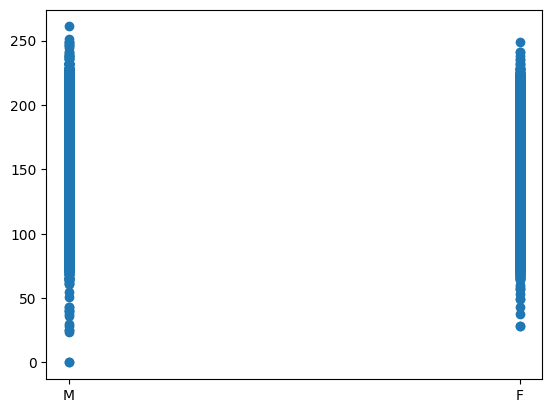

In [890]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_GENERO', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_GENERO'], df['PUNT_GLOBAL'])

dummies = pd.get_dummies(df['ESTU_GENERO'], prefix='GENERO', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [891]:
dummies = pd.get_dummies(dfTest['ESTU_GENERO'], prefix='GENERO', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_FECHANACIMIENTO -> EDAD

             PUNT_GLOBAL      EDAD
PUNT_GLOBAL     1.000000 -0.159565
EDAD           -0.159565  1.000000


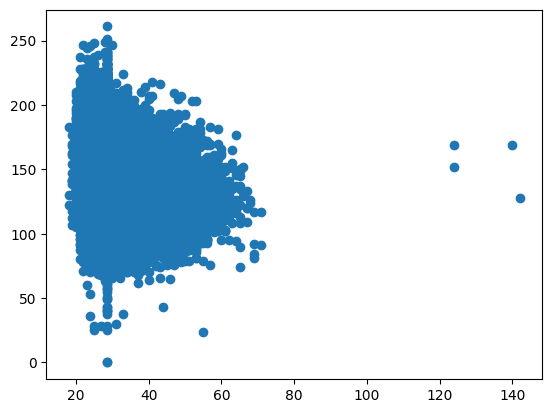

In [892]:
def calcular_edad(df, fecha_nacimiento_col):
    df[fecha_nacimiento_col] = pd.to_datetime(df[fecha_nacimiento_col], errors='coerce')
    fecha_actual = datetime.now()
    df['EDAD'] = df[fecha_nacimiento_col].apply(lambda fecha: fecha_actual.year - fecha.year - ((fecha_actual.month, fecha_actual.day) < (fecha.month, fecha.day)))
    return df

df = calcular_edad(df, 'ESTU_FECHANACIMIENTO')
MEAN = df['EDAD'].mean()
df['EDAD'] = df['EDAD'].fillna(MEAN)

dfFinal = pd.concat([dfFinal, df['EDAD']], axis=1)
print(df[['PUNT_GLOBAL', 'EDAD']].corr())
plt.scatter(df['EDAD'], df['PUNT_GLOBAL'])

In [893]:
dfTest = calcular_edad(dfTest, 'ESTU_FECHANACIMIENTO')
dfTest['EDAD'].isnull().sum()
MEAN = dfTest['EDAD'].mean()
dfTest['EDAD'] = dfTest['EDAD'].fillna(MEAN)

___

## PERIODO

              PERIODO  PUNT_GLOBAL
PERIODO      1.000000     0.081207
PUNT_GLOBAL  0.081207     1.000000


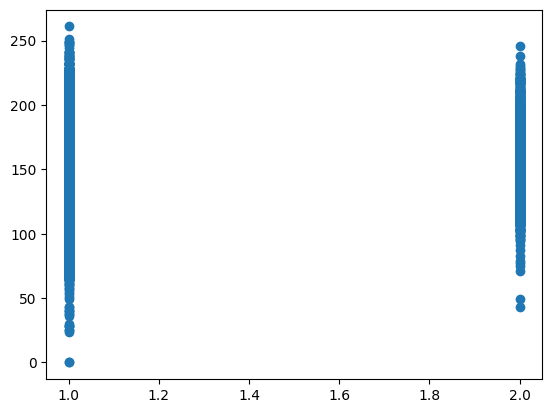

In [894]:
df['PERIODO'] = df['PERIODO'].replace({20231: 1, 20232: 2})
dfFinal = pd.concat([dfFinal, df['PERIODO']], axis=1)
print(df[['PERIODO', 'PUNT_GLOBAL']].corr())
plt.scatter(df['PERIODO'], df['PUNT_GLOBAL'])

In [895]:
dfTest['PERIODO'] = dfTest['PERIODO'].replace({20231: 1, 20232: 2})


___

## ESTU_DEPTO_RESIDE

AMAZONAS           -0.012542
ANTIOQUIA           0.044418
ARAUCA             -0.029147
ATLANTICO          -0.025406
BERLIN              0.001066
BOGOTÁ              0.151993
BOLIVAR            -0.035885
BOYACA              0.024012
CALDAS              0.020374
CALGARY             0.000172
CAQUETA            -0.038274
CASANARE           -0.030258
CAUCA              -0.034371
CESAR              -0.062204
CHOCO              -0.093778
CORDOBA            -0.046188
CUNDINAMARCA        0.016894
EXTRANJERO          0.027038
FLANDES ORIENTAL    0.000695
GUADALAJARA         0.004131
GUAINIA            -0.008825
GUAVIARE           -0.015259
HUILA              -0.041753
LA GUAJIRA         -0.064922
LIMA               -0.000722
MADRID             -0.003915
MAGDALENA          -0.028532
MELBOURNE           0.001577
META               -0.035622
MIAMI               0.005572
NARIÑO             -0.038343
NORTE SANTANDER    -0.024693
NUEVA YORK          0.002982
PARIS               0.010900
PUTUMAYO      

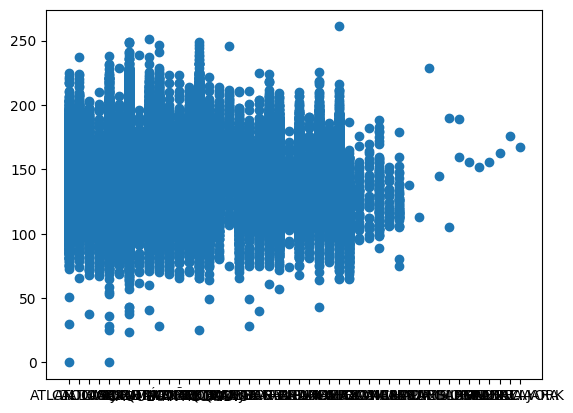

In [896]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_DEPTO_RESIDE', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_DEPTO_RESIDE'], df['PUNT_GLOBAL'])

dummies = pd.get_dummies(df['ESTU_DEPTO_RESIDE'], prefix='ESTU_DEPTO_RESIDE', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [897]:
dummies = pd.get_dummies(dfTest['ESTU_DEPTO_RESIDE'], prefix='ESTU_DEPTO_RESIDE', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_AREARESIDE

In [898]:
MODA = df['ESTU_AREARESIDE'].value_counts().idxmax()
df['ESTU_AREARESIDE'] = df['ESTU_AREARESIDE'].fillna(MODA)

Area Rural           -0.129077
Cabecera Municipal    0.129077
dtype: float64


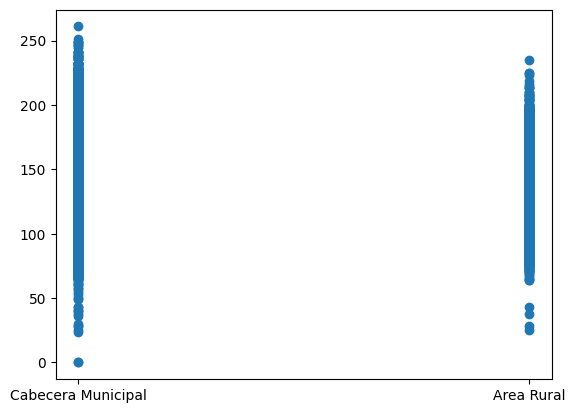

In [899]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_AREARESIDE', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_AREARESIDE'], df['PUNT_GLOBAL'])

dummies = pd.get_dummies(df['ESTU_AREARESIDE'], prefix='AREARESIDE', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [900]:
MODA = dfTest['ESTU_AREARESIDE'].value_counts().idxmax()
dfTest['ESTU_AREARESIDE'] = dfTest['ESTU_AREARESIDE'].fillna(MODA)
dummies = pd.get_dummies(dfTest['ESTU_AREARESIDE'], prefix='AREARESIDE', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_TITULOOBTENIDOBACHILLER

In [901]:
MODA = df['ESTU_TITULOOBTENIDOBACHILLER'].value_counts().idxmax()
df['ESTU_TITULOOBTENIDOBACHILLER'] = df['ESTU_TITULOOBTENIDOBACHILLER'].fillna(MODA)

Bachiller académico                  0.025790
Bachiller pedagógico o normalista   -0.004141
Bachiller técnico                   -0.025083
dtype: float64


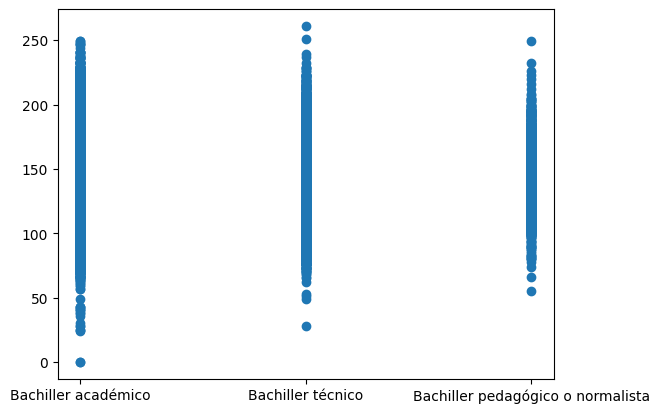

In [902]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_TITULOOBTENIDOBACHILLER', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_TITULOOBTENIDOBACHILLER'], df['PUNT_GLOBAL'])

dummies = pd.get_dummies(df['ESTU_TITULOOBTENIDOBACHILLER'], prefix='TITULOOBTENIDOBACHILLER', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [903]:
MODA = dfTest['ESTU_TITULOOBTENIDOBACHILLER'].value_counts().idxmax()
dfTest['ESTU_TITULOOBTENIDOBACHILLER'] = dfTest['ESTU_TITULOOBTENIDOBACHILLER'].fillna(MODA)

dummies = pd.get_dummies(dfTest['ESTU_TITULOOBTENIDOBACHILLER'], prefix='TITULOOBTENIDOBACHILLER', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_VALORMATRICULAUNIVERSIDAD

In [904]:
MODA = df['ESTU_VALORMATRICULAUNIVERSIDAD'].value_counts().idxmax()
df['ESTU_VALORMATRICULAUNIVERSIDAD'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna(MODA)

Entre 1 millón y menos de 2.5 millones     -0.144575
Entre 2.5 millones y menos de 4 millones   -0.085131
Entre 4 millones y menos de 5.5 millones    0.013439
Entre 5.5 millones y menos de 7 millones    0.059240
Entre 500 mil y menos de 1 millón           0.008578
Menos de 500 mil                            0.033690
Más de 7 millones                           0.244534
No pagó matrícula                           0.006933
dtype: float64


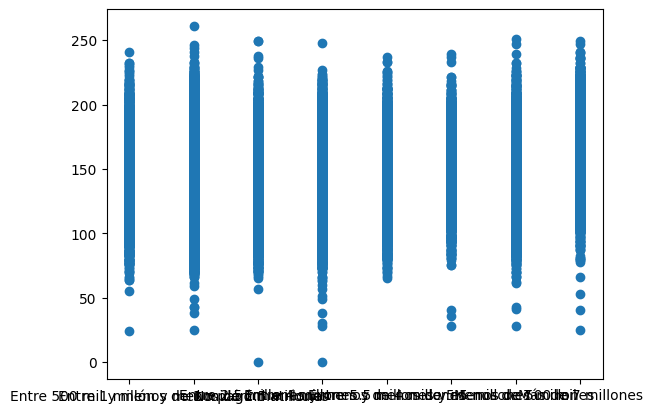

In [905]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_VALORMATRICULAUNIVERSIDAD', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_VALORMATRICULAUNIVERSIDAD'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['ESTU_VALORMATRICULAUNIVERSIDAD'], prefix='VALORMATRICULA',drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [906]:
MODA = dfTest['ESTU_VALORMATRICULAUNIVERSIDAD'].value_counts().idxmax()
dfTest['ESTU_VALORMATRICULAUNIVERSIDAD'] = dfTest['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna(MODA)

dummies = pd.get_dummies(dfTest['ESTU_VALORMATRICULAUNIVERSIDAD'], prefix='VALORMATRICULA',drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_PAGOMATRICULA

In [907]:
MODA = df['ESTU_PAGOMATRICULA'].value_counts().idxmax()
df['ESTU_PAGOMATRICULA'] = df['ESTU_PAGOMATRICULA'].fillna(MODA)

 Propios            -0.071087
Becas o Subsidios    0.065554
Creditos            -0.107903
Familiares           0.107739
dtype: float64


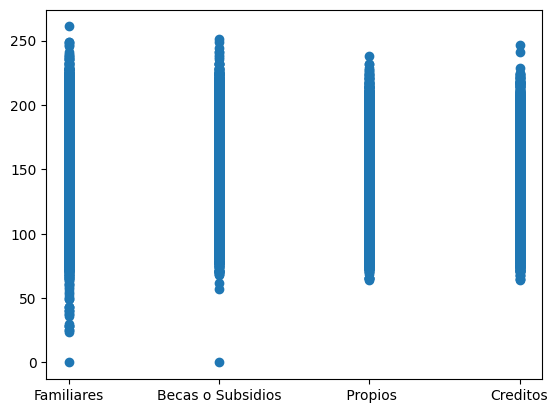

In [908]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_PAGOMATRICULA', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_PAGOMATRICULA'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['ESTU_PAGOMATRICULA'], prefix='PAGOMATRICULA', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [909]:
MODA = dfTest['ESTU_PAGOMATRICULA'].value_counts().idxmax()
dfTest['ESTU_PAGOMATRICULA'] = dfTest['ESTU_PAGOMATRICULA'].fillna(MODA)

dummies = pd.get_dummies(dfTest['ESTU_PAGOMATRICULA'], prefix='PAGOMATRICULA', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_COMOCAPACITOEXAMENSB11

In [910]:
MODA = df['ESTU_COMOCAPACITOEXAMENSB11'].value_counts().idxmax()
df['ESTU_COMOCAPACITOEXAMENSB11'] = df['ESTU_COMOCAPACITOEXAMENSB11'].fillna(MODA)

No realizó ninguna prueba de preparación    0.091734
Repasó por cuenta propia                   -0.083364
Tomó un curso de preparación               -0.002553
dtype: float64


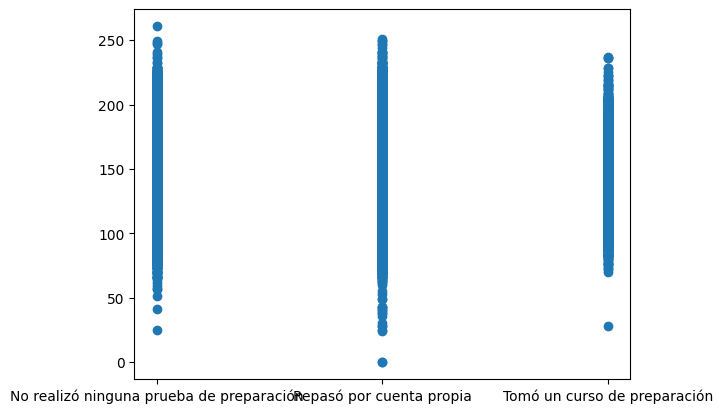

In [911]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_COMOCAPACITOEXAMENSB11', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_COMOCAPACITOEXAMENSB11'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['ESTU_COMOCAPACITOEXAMENSB11'], prefix='COMOCAPACITOEXAMENSB11', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [912]:
MODA = dfTest['ESTU_COMOCAPACITOEXAMENSB11'].value_counts().idxmax()
dfTest['ESTU_COMOCAPACITOEXAMENSB11'] = dfTest['ESTU_COMOCAPACITOEXAMENSB11'].fillna(MODA)

dummies = pd.get_dummies(dfTest['ESTU_COMOCAPACITOEXAMENSB11'], prefix='COMOCAPACITOEXAMENSB11', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_SEMESTRECURSA

In [913]:
MODA = df['ESTU_SEMESTRECURSA'].value_counts().idxmax()
df['ESTU_SEMESTRECURSA'] = df['ESTU_SEMESTRECURSA'].fillna(MODA)
df['ESTU_SEMESTRECURSA'] = df['ESTU_SEMESTRECURSA'].replace('12 o más', 12)
df['ESTU_SEMESTRECURSA'] = df['ESTU_SEMESTRECURSA'].astype(int)

                    ESTU_SEMESTRECURSA  PUNT_GLOBAL
ESTU_SEMESTRECURSA            1.000000     0.084303
PUNT_GLOBAL                   0.084303     1.000000


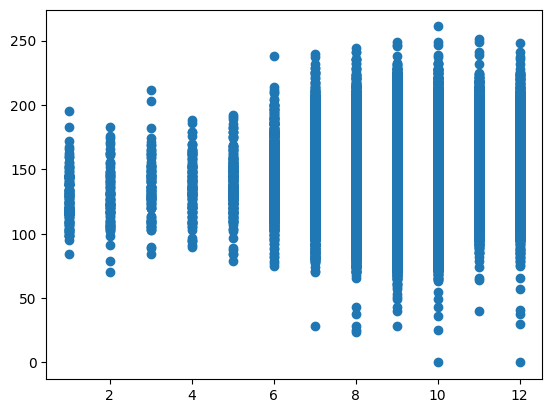

In [914]:
dfFinal = pd.concat([dfFinal, df['ESTU_SEMESTRECURSA']], axis=1)
print(df[['ESTU_SEMESTRECURSA', 'PUNT_GLOBAL']].corr())
plt.scatter(df['ESTU_SEMESTRECURSA'], df['PUNT_GLOBAL'])

In [915]:
MODA = dfTest['ESTU_SEMESTRECURSA'].value_counts().idxmax()
dfTest['ESTU_SEMESTRECURSA'] = dfTest['ESTU_SEMESTRECURSA'].fillna(MODA)
dfTest['ESTU_SEMESTRECURSA'] = dfTest['ESTU_SEMESTRECURSA'].replace('12 o más', 12)
dfTest['ESTU_SEMESTRECURSA'] = dfTest['ESTU_SEMESTRECURSA'].astype(int)

___

## FAMI_EDUCACIONPADRE

In [916]:
MODA = df['FAMI_EDUCACIONPADRE'].value_counts().idxmax()
df['FAMI_EDUCACIONPADRE'] = df['FAMI_EDUCACIONPADRE'].fillna(MODA)

Educación profesional completa          0.123877
Educación profesional incompleta        0.030915
Ninguno                                -0.116865
No Aplica                              -0.002010
No sabe                                 0.032630
Postgrado                               0.180393
Primaria completa                      -0.055951
Primaria incompleta                    -0.131887
Secundaria (Bachillerato) completa     -0.011125
Secundaria (Bachillerato) incompleta   -0.031993
Técnica o tecnológica completa          0.047908
Técnica o tecnológica incompleta       -0.006888
dtype: float64


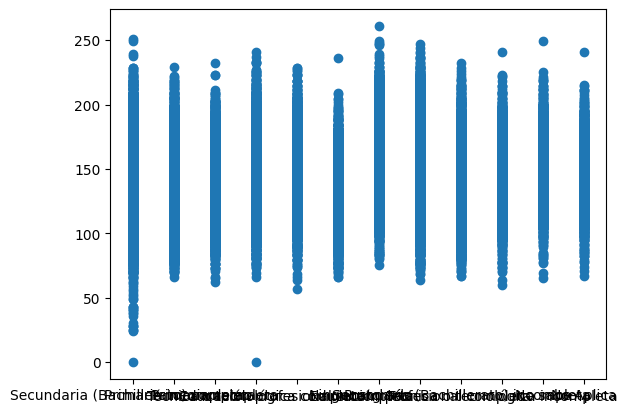

In [917]:
correlaciones = calcular_correlacion_dummies(df, 'FAMI_EDUCACIONPADRE', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['FAMI_EDUCACIONPADRE'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['FAMI_EDUCACIONPADRE'], prefix='EDUCACIONPADRE', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [918]:
MODA = dfTest['FAMI_EDUCACIONPADRE'].value_counts().idxmax()
dfTest['FAMI_EDUCACIONPADRE'] = dfTest['FAMI_EDUCACIONPADRE'].fillna(MODA)

dummies = pd.get_dummies(dfTest['FAMI_EDUCACIONPADRE'], prefix='EDUCACIONPADRE', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## FAMI_EDUCACIONMADRE

In [919]:
MODA = df['FAMI_EDUCACIONMADRE'].value_counts().idxmax()
df['FAMI_EDUCACIONMADRE'] = df['FAMI_EDUCACIONMADRE'].fillna(MODA)

Educación profesional completa          0.142594
Educación profesional incompleta        0.040440
Ninguno                                -0.107388
No Aplica                              -0.023433
No sabe                                 0.001842
Postgrado                               0.174791
Primaria completa                      -0.068094
Primaria incompleta                    -0.141577
Secundaria (Bachillerato) completa     -0.019821
Secundaria (Bachillerato) incompleta   -0.043618
Técnica o tecnológica completa          0.049702
Técnica o tecnológica incompleta       -0.013441
dtype: float64


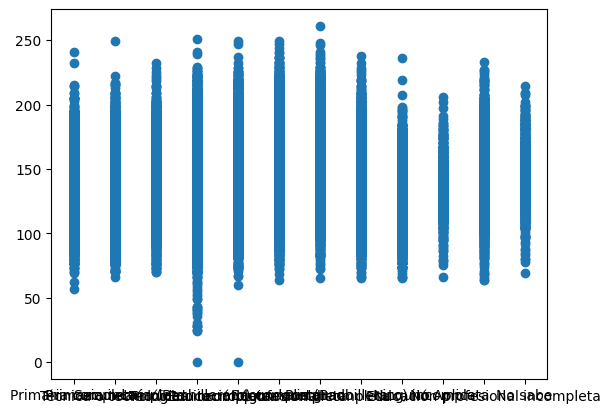

In [920]:
correlaciones = calcular_correlacion_dummies(df, 'FAMI_EDUCACIONMADRE', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['FAMI_EDUCACIONMADRE'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['FAMI_EDUCACIONMADRE'], prefix='EDUCACIONMADRE', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [921]:
MODA = dfTest['FAMI_EDUCACIONMADRE'].value_counts().idxmax()
dfTest['FAMI_EDUCACIONMADRE'] = dfTest['FAMI_EDUCACIONMADRE'].fillna(MODA)
dummies = pd.get_dummies(dfTest['FAMI_EDUCACIONMADRE'], prefix='EDUCACIONMADRE', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## FAMI_ESTRATOVIVIENDA

In [922]:
MODA = df['FAMI_ESTRATOVIVIENDA'].value_counts().idxmax()
df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].fillna(MODA)

In [923]:
df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].replace({
    'Estrato 1': 1,
    'Estrato 2': 2,
    'Estrato 3': 3,
    'Estrato 4': 4,
    'Estrato 5': 5,
    'Estrato 6': 6,
    'Sin Estrato': 0
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_16624\4120554201.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].replace({


0   -0.037404
1   -0.160728
2   -0.072688
3    0.076760
4    0.143866
5    0.112342
6    0.087452
dtype: float64


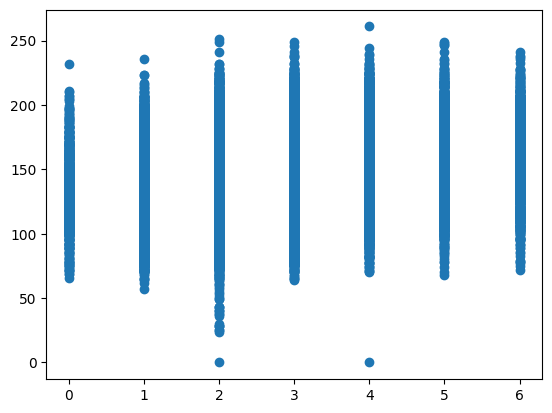

In [924]:
correlaciones = calcular_correlacion_dummies(df, 'FAMI_ESTRATOVIVIENDA', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['FAMI_ESTRATOVIVIENDA'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['FAMI_ESTRATOVIVIENDA'], prefix='ESTRATO', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [925]:
MODA = dfTest['FAMI_ESTRATOVIVIENDA'].value_counts().idxmax()
dfTest['FAMI_ESTRATOVIVIENDA'] = dfTest['FAMI_ESTRATOVIVIENDA'].fillna(MODA)
dfTest['FAMI_ESTRATOVIVIENDA'] = dfTest['FAMI_ESTRATOVIVIENDA'].replace({
    'Estrato 1': 1,
    'Estrato 2': 2,
    'Estrato 3': 3,
    'Estrato 4': 4,
    'Estrato 5': 5,
    'Estrato 6': 6,
    'Sin Estrato': 0
})
dummies = pd.get_dummies(dfTest['FAMI_ESTRATOVIVIENDA'], prefix='ESTRATO', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

C:\Users\Migue\AppData\Local\Temp\ipykernel_16624\4071353882.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfTest['FAMI_ESTRATOVIVIENDA'] = dfTest['FAMI_ESTRATOVIVIENDA'].replace({


___

## FAMI_TIENEINTERNET

In [926]:
MODA = df['FAMI_TIENEINTERNET'].value_counts().idxmax()
df['FAMI_TIENEINTERNET'] = df['FAMI_TIENEINTERNET'].fillna(MODA)

In [927]:
df['TIENEINTERNET'] = df['FAMI_TIENEINTERNET'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_16624\3439167256.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TIENEINTERNET'] = df['FAMI_TIENEINTERNET'].replace({


               PUNT_GLOBAL  TIENEINTERNET
PUNT_GLOBAL       1.000000       0.141491
TIENEINTERNET     0.141491       1.000000


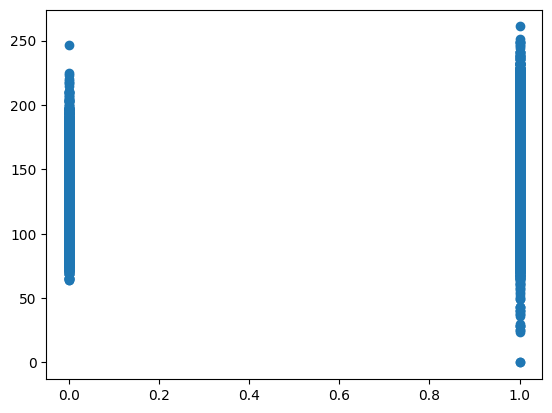

In [928]:
print(df[['PUNT_GLOBAL', 'TIENEINTERNET']].corr())
plt.scatter(df['TIENEINTERNET'], df['PUNT_GLOBAL'])
dfFinal = pd.concat([dfFinal, df['TIENEINTERNET']], axis=1)

In [929]:
MODA = dfTest['FAMI_TIENEINTERNET'].value_counts().idxmax()
dfTest['FAMI_TIENEINTERNET'] = dfTest['FAMI_TIENEINTERNET'].fillna(MODA)
dfTest['TIENEINTERNET'] = dfTest['FAMI_TIENEINTERNET'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_16624\2982809549.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfTest['TIENEINTERNET'] = dfTest['FAMI_TIENEINTERNET'].replace({


___

## FAMI_TIENESERVICIOTV

In [930]:
MODA = df['FAMI_TIENESERVICIOTV'].value_counts().idxmax()
df['FAMI_TIENESERVICIOTV'] = df['FAMI_TIENESERVICIOTV'].fillna(MODA)

In [931]:
df['TIENESERVICIOTV'] = df['FAMI_TIENESERVICIOTV'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_16624\485018897.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TIENESERVICIOTV'] = df['FAMI_TIENESERVICIOTV'].replace({


                 PUNT_GLOBAL  TIENESERVICIOTV
PUNT_GLOBAL         1.000000         0.040291
TIENESERVICIOTV     0.040291         1.000000


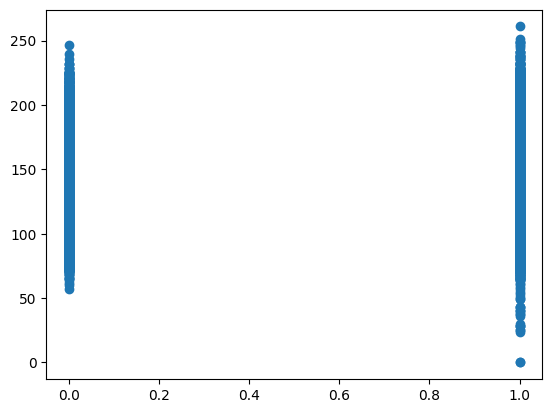

In [932]:
print(df[['PUNT_GLOBAL', 'TIENESERVICIOTV']].corr())
plt.scatter(df['TIENESERVICIOTV'], df['PUNT_GLOBAL'])
dfFinal = pd.concat([dfFinal, df['TIENESERVICIOTV']], axis=1)

In [933]:
MODA = dfTest['FAMI_TIENESERVICIOTV'].value_counts().idxmax()
dfTest['FAMI_TIENESERVICIOTV'] = dfTest['FAMI_TIENESERVICIOTV'].fillna(MODA)
dfTest['TIENESERVICIOTV'] = dfTest['FAMI_TIENESERVICIOTV'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_16624\3525001120.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfTest['TIENESERVICIOTV'] = dfTest['FAMI_TIENESERVICIOTV'].replace({


___

## FAMI_TIENECOMPUTADOR

In [934]:
MODA = df['FAMI_TIENECOMPUTADOR'].value_counts().idxmax()
df['FAMI_TIENECOMPUTADOR'] = df['FAMI_TIENECOMPUTADOR'].fillna(MODA)

In [935]:
df['TIENECOMPUTADOR'] = df['FAMI_TIENECOMPUTADOR'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_16624\4249773009.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TIENECOMPUTADOR'] = df['FAMI_TIENECOMPUTADOR'].replace({


                 PUNT_GLOBAL  TIENECOMPUTADOR
PUNT_GLOBAL         1.000000         0.147503
TIENECOMPUTADOR     0.147503         1.000000


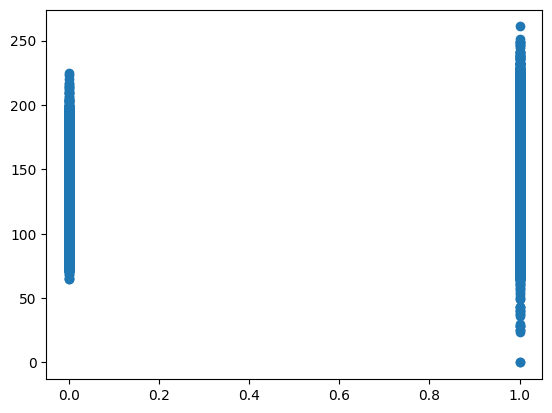

In [936]:
print(df[['PUNT_GLOBAL', 'TIENECOMPUTADOR']].corr())
plt.scatter(df['TIENECOMPUTADOR'], df['PUNT_GLOBAL'])
dfFinal = pd.concat([dfFinal, df['TIENECOMPUTADOR']], axis=1)

In [937]:
MODA = dfTest['FAMI_TIENECOMPUTADOR'].value_counts().idxmax()
dfTest['FAMI_TIENECOMPUTADOR'] = dfTest['FAMI_TIENECOMPUTADOR'].fillna(MODA)
dfTest['TIENECOMPUTADOR'] = dfTest['FAMI_TIENECOMPUTADOR'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_16624\4032842601.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfTest['TIENECOMPUTADOR'] = dfTest['FAMI_TIENECOMPUTADOR'].replace({


___

## FAMI_TIENECONSOLAVIDEOJUEGOS

In [938]:
MODA = df['FAMI_TIENECONSOLAVIDEOJUEGOS'].value_counts().idxmax()
df['FAMI_TIENECONSOLAVIDEOJUEGOS'] = df['FAMI_TIENECONSOLAVIDEOJUEGOS'].fillna(MODA)

In [939]:
df['TIENECONSOLAVIDEOJUEGOS'] = df['FAMI_TIENECONSOLAVIDEOJUEGOS'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_16624\2147797429.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TIENECONSOLAVIDEOJUEGOS'] = df['FAMI_TIENECONSOLAVIDEOJUEGOS'].replace({


                         PUNT_GLOBAL  TIENECONSOLAVIDEOJUEGOS
PUNT_GLOBAL                   1.0000                   0.1398
TIENECONSOLAVIDEOJUEGOS       0.1398                   1.0000


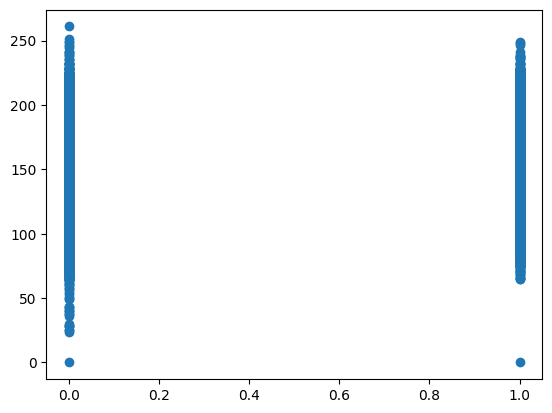

In [940]:
print(df[['PUNT_GLOBAL', 'TIENECONSOLAVIDEOJUEGOS']].corr())
plt.scatter(df['TIENECONSOLAVIDEOJUEGOS'], df['PUNT_GLOBAL'])
dfFinal = pd.concat([dfFinal, df['TIENECONSOLAVIDEOJUEGOS']], axis=1)

In [941]:
MODA = dfTest['FAMI_TIENECONSOLAVIDEOJUEGOS'].value_counts().idxmax()
dfTest['FAMI_TIENECONSOLAVIDEOJUEGOS'] = dfTest['FAMI_TIENECONSOLAVIDEOJUEGOS'].fillna(MODA)
dfTest['TIENECONSOLAVIDEOJUEGOS'] = dfTest['FAMI_TIENECONSOLAVIDEOJUEGOS'].replace({
    'Si': True,
    'No': False
})

C:\Users\Migue\AppData\Local\Temp\ipykernel_16624\4255556452.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfTest['TIENECONSOLAVIDEOJUEGOS'] = dfTest['FAMI_TIENECONSOLAVIDEOJUEGOS'].replace({


___

## ESTU_HORASSEMANATRABAJA

In [942]:
MODA = df['ESTU_HORASSEMANATRABAJA'].value_counts().idxmax()
df['ESTU_HORASSEMANATRABAJA'] = df['ESTU_HORASSEMANATRABAJA'].fillna(MODA)

0                      0.124040
Entre 11 y 20 horas   -0.017382
Entre 21 y 30 horas   -0.024759
Menos de 10 horas     -0.012972
Más de 30 horas       -0.047126
dtype: float64


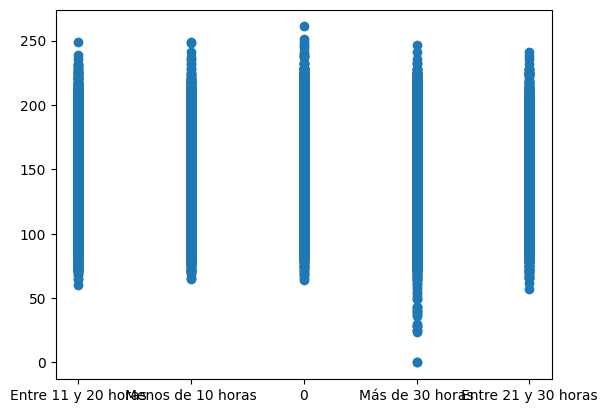

In [943]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_HORASSEMANATRABAJA', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_HORASSEMANATRABAJA'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['ESTU_HORASSEMANATRABAJA'], prefix='HORASSEMANATRABAJA', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [944]:
MODA = dfTest['ESTU_HORASSEMANATRABAJA'].value_counts().idxmax()
dfTest['ESTU_HORASSEMANATRABAJA'] = dfTest['ESTU_HORASSEMANATRABAJA'].fillna(MODA)
dummies = pd.get_dummies(dfTest['ESTU_HORASSEMANATRABAJA'], prefix='HORASSEMANATRABAJA', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## GRUPOREFERENCIA

In [945]:
MODA = df['GRUPOREFERENCIA'].value_counts().idxmax()
df['GRUPOREFERENCIA'] = df['GRUPOREFERENCIA'].fillna(MODA)

ADMINISTRACIÓN Y AFINES                                         -0.109796
ARQUITECTURA Y URBANISMO                                         0.036820
BELLAS ARTES Y DISEÑO                                            0.049641
CIENCIAS AGROPECUARIAS                                          -0.005863
CIENCIAS MILITARES Y NAVALES                                    -0.000831
CIENCIAS NATURALES Y EXACTAS                                     0.089071
CIENCIAS SOCIALES                                                0.002172
COMUNICACIÓN, PERIODISMO Y PUBLICIDAD                            0.029368
CONTADURÍA Y AFINES                                             -0.070248
DERECHO                                                          0.051178
ECONOMÍA                                                         0.066078
ECONOMÍA, ADMINISTRACIÓN, CONTADURÍA Y AFINES - UNIVERSITARIA    0.008615
EDUCACIÓN                                                       -0.047192
ENFERMERÍA                            

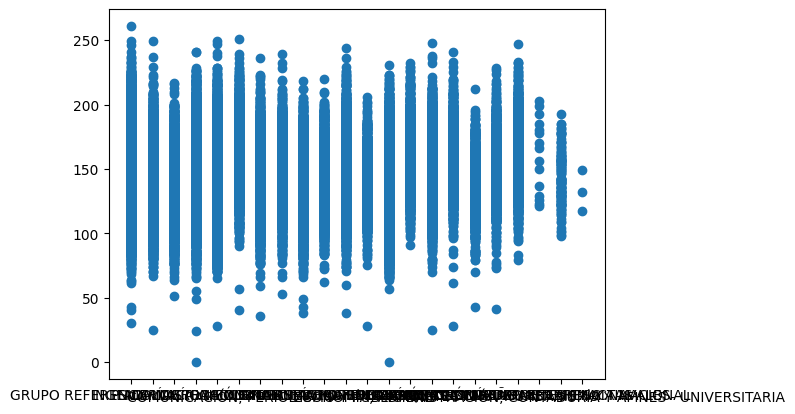

In [946]:
correlaciones = calcular_correlacion_dummies(df, 'GRUPOREFERENCIA', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['GRUPOREFERENCIA'], df['PUNT_GLOBAL'])
dummies = pd.get_dummies(df['GRUPOREFERENCIA'], prefix='GRUPOREFERENCIA', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [947]:
MODA = dfTest['GRUPOREFERENCIA'].value_counts().idxmax()
dfTest['GRUPOREFERENCIA'] = dfTest['GRUPOREFERENCIA'].fillna(MODA)
dummies = pd.get_dummies(dfTest['GRUPOREFERENCIA'], prefix='GRUPOREFERENCIA', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_PRGM_DEPARTAMENTO

ANTIOQUIA          0.058824
ARAUCA            -0.022884
ATLANTICO         -0.018300
BOGOTÁ            -0.001195
BOLIVAR           -0.027587
BOYACA             0.046345
CALDAS             0.043944
CAQUETA           -0.023293
CASANARE          -0.008270
CAUCA             -0.016484
CESAR             -0.037045
CHOCO             -0.094030
CORDOBA           -0.028700
CUNDINAMARCA       0.083099
GUAINIA            0.000217
GUAVIARE          -0.001988
HUILA             -0.014252
LA GUAJIRA        -0.055752
MAGDALENA         -0.018739
META              -0.011934
NARIÑO            -0.021980
NORTE SANTANDER   -0.026063
PUTUMAYO          -0.010752
QUINDIO            0.013959
RISARALDA          0.018337
SANTANDER          0.040094
SUCRE             -0.036276
TOLIMA            -0.029218
VALLE              0.013889
dtype: float64


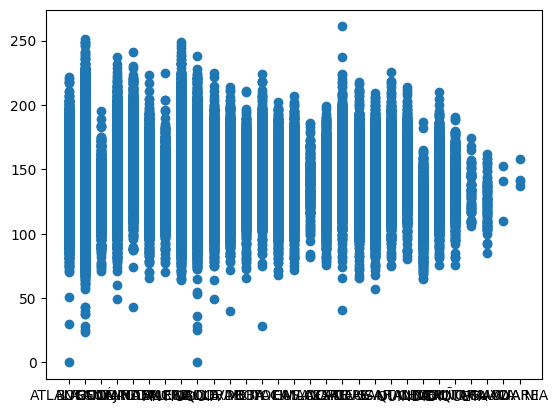

In [948]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_PRGM_DEPARTAMENTO', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_PRGM_DEPARTAMENTO'], df['PUNT_GLOBAL'])

dummies = pd.get_dummies(df['ESTU_PRGM_DEPARTAMENTO'], prefix='ESTU_PRGM_DEPARTAMENTO', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [949]:
dummies = pd.get_dummies(dfTest['ESTU_PRGM_DEPARTAMENTO'], prefix='ESTU_PRGM_DEPARTAMENTO', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_METODO_PRGM

DISTANCIA          -0.187069
DISTANCIA VITUAL   -0.107896
PRESENCIAL          0.226862
dtype: float64


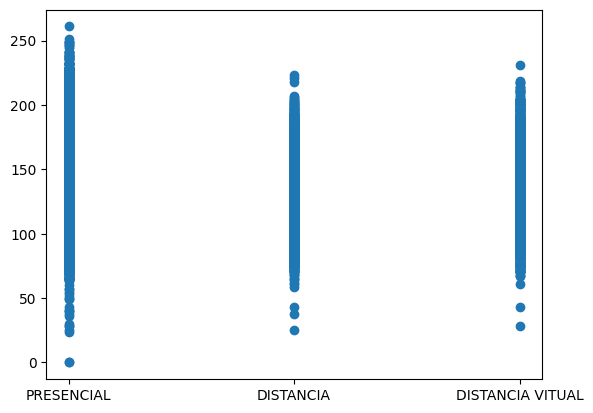

In [950]:
correlaciones = calcular_correlacion_dummies(df, 'ESTU_METODO_PRGM', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['ESTU_METODO_PRGM'], df['PUNT_GLOBAL'])

dummies = pd.get_dummies(df['ESTU_METODO_PRGM'], prefix='METODO_ESTUDIO', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [951]:
dummies = pd.get_dummies(dfTest['ESTU_METODO_PRGM'], prefix='METODO_ESTUDIO', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## INST_CARACTER_ACADEMICO

INSTITUCIÓN TECNOLÓGICA     -0.115303
INSTITUCIÓN UNIVERSITARIA   -0.223687
TÉCNICA PROFESIONAL         -0.069109
UNIVERSIDAD                  0.292784
dtype: float64


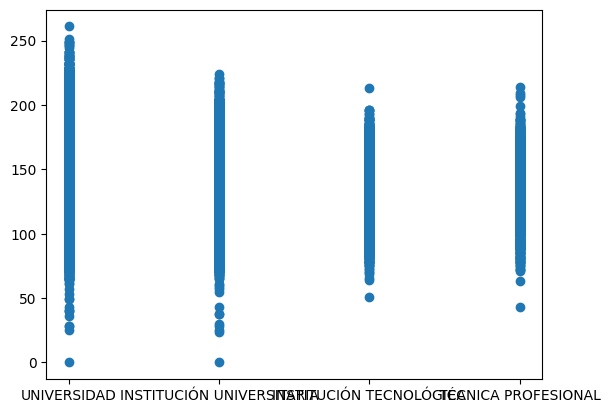

In [952]:
correlaciones = calcular_correlacion_dummies(df, 'INST_CARACTER_ACADEMICO', 'PUNT_GLOBAL')
print(correlaciones)
plt.scatter(df['INST_CARACTER_ACADEMICO'], df['PUNT_GLOBAL'])

dummies = pd.get_dummies(df['INST_CARACTER_ACADEMICO'], prefix='INST_CARACTER', drop_first=True)
df = pd.concat([df, dummies], axis=1)
dfFinal = pd.concat([dfFinal, dummies], axis=1)

In [953]:
dummies = pd.get_dummies(dfTest['INST_CARACTER_ACADEMICO'], prefix='INST_CARACTER', drop_first=True)
dfTest = pd.concat([dfTest, dummies], axis=1)

___

## ESTU_INSE_INDIVIDUAL, ESTU_NSE_IES

In [954]:
MEAN = df['ESTU_INSE_INDIVIDUAL'].mean()
df['ESTU_INSE_INDIVIDUAL'] = df['ESTU_INSE_INDIVIDUAL'].fillna(MEAN)

MEAN = df['ESTU_NSE_IES'].mean()
df['ESTU_NSE_IES'] = df['ESTU_NSE_IES'].fillna(MEAN)

                      PUNT_GLOBAL  ESTU_INSE_INDIVIDUAL  ESTU_NSE_IES
PUNT_GLOBAL              1.000000              0.238292      0.262818
ESTU_INSE_INDIVIDUAL     0.238292              1.000000      0.340678
ESTU_NSE_IES             0.262818              0.340678      1.000000


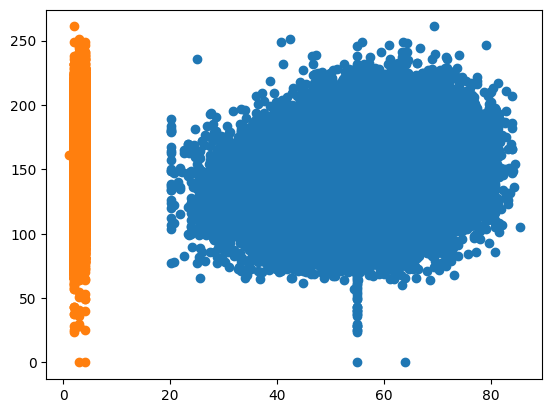

In [955]:
print(df[['PUNT_GLOBAL', 'ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_IES']].corr())
plt.scatter(df['ESTU_INSE_INDIVIDUAL'], df['PUNT_GLOBAL'])
plt.scatter(df['ESTU_NSE_IES'], df['PUNT_GLOBAL'])
dfFinal = pd.concat([dfFinal, df[['ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_IES']]], axis=1)

In [956]:
MEAN = dfTest['ESTU_INSE_INDIVIDUAL'].mean()
dfTest['ESTU_INSE_INDIVIDUAL'] = dfTest['ESTU_INSE_INDIVIDUAL'].fillna(MEAN)

MEAN = dfTest['ESTU_NSE_IES'].mean()
dfTest['ESTU_NSE_IES'] = dfTest['ESTU_NSE_IES'].fillna(MEAN)

___

# Regresión

In [957]:
dfFinal.drop(columns=['ESTU_DEPTO_RESIDE_BERLIN', 'ESTU_DEPTO_RESIDE_CALGARY', 'ESTU_DEPTO_RESIDE_FLANDES ORIENTAL', 'ESTU_DEPTO_RESIDE_GUADALAJARA', 'ESTU_DEPTO_RESIDE_LIMA', 'ESTU_DEPTO_RESIDE_MADRID', 'ESTU_DEPTO_RESIDE_MELBOURNE', 'ESTU_DEPTO_RESIDE_MIAMI', 'ESTU_DEPTO_RESIDE_NUEVA YORK', 'ESTU_DEPTO_RESIDE_PARIS', 'ESTU_DEPTO_RESIDE_VALENCIA'], inplace=True)

In [958]:
X = dfFinal.drop(columns=['PUNT_GLOBAL'])  # Variables predictoras
y = dfFinal['PUNT_GLOBAL']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

r2 = r2_score(y_test, y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)

print(f"R²: {r2}")
print(f"MAPE: {mape}")
print(f"MSE: {mse}")


R²: 0.29869430595889135
MAPE: 21060818067374.6
MSE: 386.5765870797364


In [959]:
y_pred = modelo.predict(dfTest[list(X.columns)])

resultado = pd.DataFrame({
    'id': dfTest['ESTU_CONSECUTIVO'],
    'GLOBAL_SCORE': y_pred
})

resultado.to_csv('submissions/regresion.csv', index=False)


___

# KNN

In [960]:
X = dfFinal.drop(columns=['PUNT_GLOBAL'])
y = dfFinal['PUNT_GLOBAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

vecinos_a_probar = [5, 10, 20, 30, 40, 50, 60]
resultados_mse = {}

for k in vecinos_a_probar:
    knn = KNeighborsRegressor(n_neighbors=k)
    
    knn.fit(X_train_scaled, y_train)
    
    y_pred = knn.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    
    resultados_mse[k] = mse
    print(f"MSE para {k} vecinos: {mse}")

mejor_k = min(resultados_mse, key=resultados_mse.get)
print(f"El mejor número de vecinos es {mejor_k} con un MSE de {resultados_mse[mejor_k]}")


MSE para 5 vecinos: 447.9034634598701
MSE para 10 vecinos: 414.6046271201651
MSE para 20 vecinos: 400.83955786891613
MSE para 30 vecinos: 397.73038233602887
MSE para 40 vecinos: 397.4434518681384
MSE para 50 vecinos: 398.0473437314906
MSE para 60 vecinos: 398.2166002074048
El mejor número de vecinos es 40 con un MSE de 397.4434518681384


In [961]:
mejor_k = 30

X_test_real = dfTest[list(X.columns)]
X_test_real_scaled = scaler.transform(X_test_real)

knn = KNeighborsRegressor(n_neighbors=mejor_k)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_real_scaled)

resultado = pd.DataFrame({
    'id': dfTest['ESTU_CONSECUTIVO'],
    'GLOBAL_SCORE': y_pred
})

resultado.to_csv('submissions/knn_submission.csv', index=False)


___

# GBM

In [962]:
X = dfFinal.drop(columns=['PUNT_GLOBAL'])
y = dfFinal['PUNT_GLOBAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

gbm.fit(X_train_scaled, y_train)

y_pred_train = gbm.predict(X_train_scaled)
y_pred_test = gbm.predict(X_test_scaled)

mse_train = mean_squared_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"MSE en entrenamiento: {mse_train}")
print(f"MAPE en entrenamiento: {mape_train}")
print(f"MSE en prueba: {mse_test}")
print(f"MAPE en prueba: {mape_test}")

MSE en entrenamiento: 381.40471831154787
MAPE en entrenamiento: 8066752201627.534
MSE en prueba: 386.80937356163315
MAPE en prueba: 20583606131073.535


In [963]:
X_test_real = dfTest[list(X.columns)]
X_test_real_scaled = scaler.transform(X_test_real)

y_pred = gbm.predict(X_test_real_scaled)

resultado = pd.DataFrame({
    'id': dfTest['ESTU_CONSECUTIVO'],
    'GLOBAL_SCORE': y_pred
})

resultado.to_csv('submissions/gbm_submission.csv', index=False)
